# Image Classification using BigTransfer (BiT)

**Author:** [Sayan Nath](https://twitter.com/sayannath2350)<br>
**Date created:** 2021/09/24<br>
**Last modified:** 2021/09/24<br>
**Description:** BigTransfer (BiT) State-of-the-art transfer learning for image classification.

## Introduction

BigTransfer (also known as BiT) is a state-of-the-art transfer learning method for image
classification. Transfer of pre-trained representations improves sample efficiency and
simplifies hyperparameter tuning when training deep neural networks for vision. BiT
revisit the paradigm of pre-training on large supervised datasets and fine-tuning the
model on a target task. The importance of appropriately choosing normalization layers and
scaling the architecture capacity as the amount of pre-training data increases.

BigTransfer(BiT) is trained on public datasets, along with code in
[TF2, Jax and Pytorch](https://github.com/google-research/big_transfer). This will help anyone to reach
state of the art performance on their task of interest, even with just a handful of
labeled images per class.

You can find BiT models pre-trained on
[ImageNet](https://image-net.org/challenges/LSVRC/2012/index) and ImageNet-21k in
[TFHub](https://tfhub.dev/google/collections/bit/1) as TensorFlow2 SavedModels that you
can use easily as Keras Layers. There are a variety of sizes ranging from a standard
ResNet50 to a ResNet152x4 (152 layers deep, 4x wider than a typical ResNet50) for users
with larger computational and memory budgets but higher accuracy requirements.

![](https://i.imgur.com/XeWVfe7.jpeg)
Figure: The x-axis shows the number of images used per class, ranging from 1 to the full
dataset. On the plots on the left, the curve in blue above is our BiT-L model, whereas
the curve below is a ResNet-50 pre-trained on ImageNet (ILSVRC-2012).

## Setup

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

SEEDS = 42

np.random.seed(SEEDS)
tf.random.set_seed(SEEDS)

## Gather Flower Dataset

In [3]:
train_ds, validation_ds = tfds.load(
    "tf_flowers",
    split=["train[:85%]", "train[85%:]"],
    as_supervised=True,
)

## Visualise the dataset

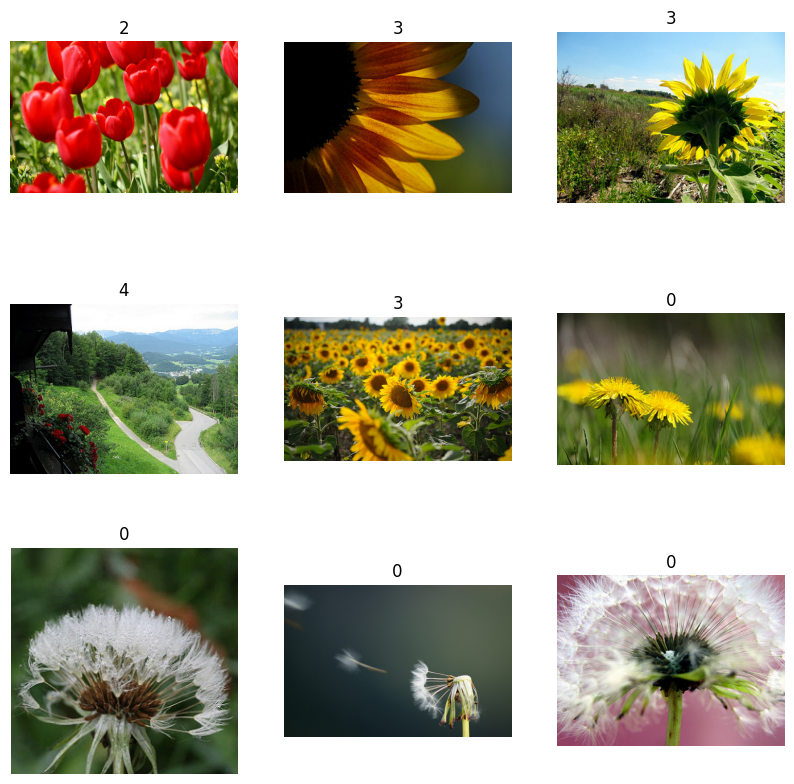

In [4]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

## Define hyperparameters

In [5]:
RESIZE_TO = 384
CROP_TO = 224
BATCH_SIZE = 64
STEPS_PER_EPOCH = 10
AUTO = tf.data.AUTOTUNE  # optimise the pipeline performance
NUM_CLASSES = 5  # number of classes
SCHEDULE_LENGTH = (
    500  # we will train on lower resolution images and will still attain good results
)
SCHEDULE_BOUNDARIES = [
    200,
    300,
    400,
]  # more the dataset size the schedule length increase

The hyperparamteres like `SCHEDULE_LENGTH` and `SCHEDULE_BOUNDARIES` are determined based
on empirical results. The method has been explained in the [original
paper](https://arxiv.org/abs/1912.11370) and in their [Google AI Blog
Post](https://ai.googleblog.com/2020/05/open-sourcing-bit-exploring-large-scale.html).

The `SCHEDULE_LENGTH` is aslo determined whether to use [MixUp
Augmentation](https://arxiv.org/abs/1710.09412) or not. You can also find an easy MixUp
Implementation in [Keras Coding Examples](https://keras.io/examples/vision/mixup/).

![](https://i.imgur.com/oSaIBYZ.jpeg)

## Define preprocessing helper functions

In [6]:
SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE


@tf.function
def preprocess_train(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.resize(image, (RESIZE_TO, RESIZE_TO))
    image = tf.image.random_crop(image, (CROP_TO, CROP_TO, 3))
    image = image / 255.0
    return (image, label)


@tf.function
def preprocess_test(image, label):
    image = tf.image.resize(image, (RESIZE_TO, RESIZE_TO))
    image = image / 255.0
    return (image, label)


DATASET_NUM_TRAIN_EXAMPLES = train_ds.cardinality().numpy()

repeat_count = int(
    SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH
)
repeat_count += 50 + 1  # To ensure at least there are 50 epochs of training

## Define the data pipeline

In [7]:
# Training pipeline
pipeline_train = (
    train_ds.shuffle(10000)
    .repeat(repeat_count)  # Repeat dataset_size / num_steps
    .map(preprocess_train, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Validation pipeline
pipeline_validation = (
    validation_ds.map(preprocess_test, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

## Visualise the training samples

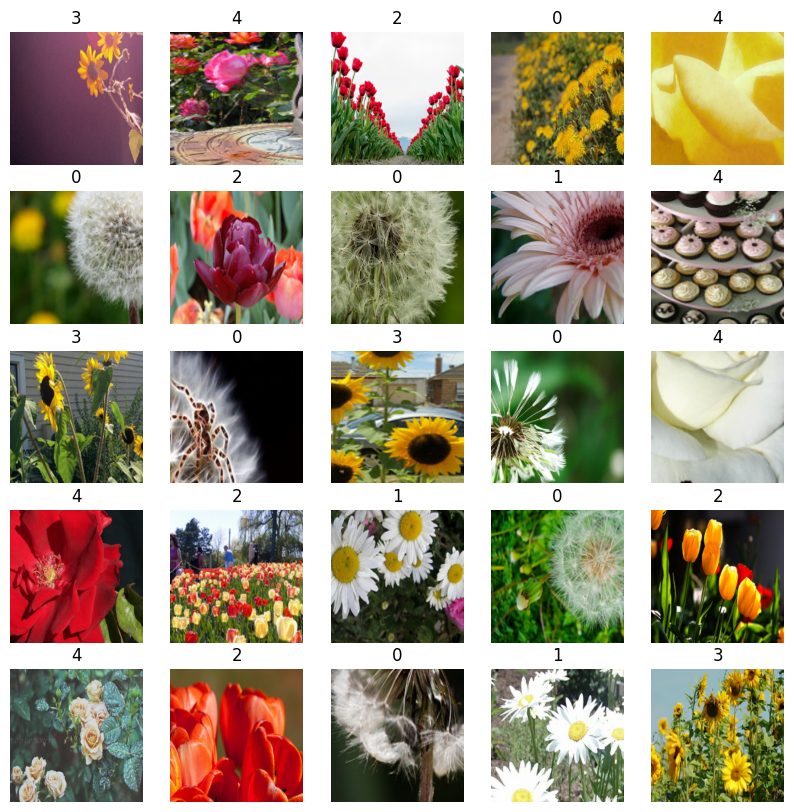

In [8]:
image_batch, label_batch = next(iter(pipeline_train))

plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(image_batch[n])
    plt.title(label_batch[n].numpy())
    plt.axis("off")

## Load pretrained TF-Hub model into a `KerasLayer`

In [9]:
bit_model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
bit_module = hub.KerasLayer(bit_model_url)

## Create BigTransfer (BiT) model

To create the new model, we:

1. Cut off the BiT model’s original head. This leaves us with the “pre-logits” output.
We do not have to do this if we use the ‘feature extractor’ models (i.e. all those in
subdirectories titled `feature_vectors`), since for those models the head has already
been cut off.

2. Add a new head with the number of outputs equal to the number of classes of our new
task. Note that it is important that we initialise the head to all zeroes.

In [10]:

class MyBiTModel(keras.Model):
    def __init__(self, num_classes, module, **kwargs):
        super().__init__(**kwargs)

        self.num_classes = num_classes
        self.head = keras.layers.Dense(num_classes, kernel_initializer="zeros")
        self.bit_model = module

    def call(self, images):
        bit_embedding = self.bit_model(images)
        return self.head(bit_embedding)


model = MyBiTModel(num_classes=NUM_CLASSES, module=bit_module)

## Define optimizer and loss

In [11]:
learning_rate = 0.003 * BATCH_SIZE / 512

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=SCHEDULE_BOUNDARIES,
    values=[
        learning_rate,
        learning_rate * 0.1,
        learning_rate * 0.01,
        learning_rate * 0.001,
    ],
)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

## Compile the model

In [12]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

## Set up callbacks

In [13]:
train_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=2, restore_best_weights=True
    )
]

## Train the model

In [14]:
history = model.fit(
    pipeline_train,
    batch_size=BATCH_SIZE,
    epochs=int(SCHEDULE_LENGTH / STEPS_PER_EPOCH),
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=pipeline_validation,
    callbacks=train_callbacks,
)

Epoch 1/400
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


10/10 [==============================] - 77s 8s/step - loss: 0.7454 - accuracy: 0.7906 - val_loss: 0.1857 - val_accuracy: 0.9618
Epoch 2/400
10/10 [==============================] - 71s 8s/step - loss: 0.1486 - accuracy: 0.9609 - val_loss: 0.1136 - val_accuracy: 0.9709
Epoch 3/400
10/10 [==============================] - 72s 8s/step - loss: 0.1633 - accuracy: 0.9484 - val_loss: 0.0855 - val_accuracy: 0.9709
Epoch 4/400
10/10 [==============================] - 72s 8s/step - loss: 0.1316 - accuracy: 0.9563 - val_loss: 0.0834 - val_accuracy: 0.9655


## Plot the training and validation metrics

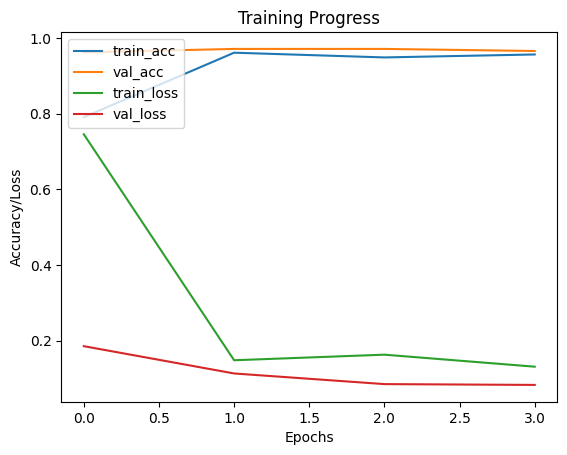

In [15]:

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Training Progress")
    plt.ylabel("Accuracy/Loss")
    plt.xlabel("Epochs")
    plt.legend(["train_acc", "val_acc", "train_loss", "val_loss"], loc="upper left")
    plt.show()


plot_hist(history)

## Evaluate the model

In [16]:
accuracy = model.evaluate(pipeline_validation)[1] * 100
model.save('my_model')
print("Accuracy: {:.2f}%".format(accuracy))

9/9 [==============================] - 52s 6s/step - loss: 0.1136 - accuracy: 0.9709


INFO:tensorflow:Assets written to: my_model\assets


INFO:tensorflow:Assets written to: my_model\assets


Accuracy: 97.09%


## Conclusion

BiT performs well across a surprisingly wide range of data regimes
-- from 1 example per class to 1M total examples. BiT achieves 87.5% top-1 accuracy on
ILSVRC-2012, 99.4% on CIFAR-10, and 76.3% on the 19 task Visual Task Adaptation Benchmark
(VTAB). On small datasets, BiT attains 76.8% on ILSVRC-2012 with 10 examples per class,
and 97.0% on CIFAR-10 with 10 examples per class.

![](https://i.imgur.com/b1Lw5fz.png)

You can experiment further with the BigTransfer Method by following the
[original paper](https://arxiv.org/abs/1912.11370).


**Example available on HuggingFace**
| Trained Model | Demo |
| :--: | :--: |
| [![Generic badge](https://img.shields.io/badge/%F0%9F%A4%97%20Model-bit-black.svg)](https://huggingface.co/keras-io/bit) | [![Generic badge](https://img.shields.io/badge/%F0%9F%A4%97%20Spaces-bit-black.svg)](https://huggingface.co/spaces/keras-io/siamese-contrastive) |